## Data Loading and Environment Setup

In [1]:
import os
import math
import joblib
import time
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import requests
from io import BytesIO
from PIL import Image

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA

import torch
from transformers import CLIPProcessor, CLIPModel

DATA_PATH = "/kaggle/input/trending-yt-vids-lk/trending_dataset_cleaned.csv"   # change to your path
OUT_DIR = "pipeline_artifacts"
os.makedirs(OUT_DIR, exist_ok=True)

CLIP_MODEL_NAME = "openai/clip-vit-base-patch32"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

EMBED_BATCH_SIZE = 32           # reduce if you hit OOM
TEXT_BATCH_SIZE = 32
IMAGE_BATCH_SIZE = 32

TRY_USE_IMAGES = True           # set False to skip image embeddings (much faster / lighter)
ENGAGEMENT_COL = None           # e.g. "views" if you want to weight slots by engagement; or None

K_RANGE = list(range(2, 13))    # range of k to try for KMeans
ALTERNATIVE_N_CLUSTERS = 8     # initial pick for other algorithms
TOP_K_SLOTS = 5

MIN_CLUSTER_SAMPLES = 20        # clusters with fewer samples flagged as low-confidence

2025-09-17 01:51:21.609094: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758073881.838510      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758073881.901269      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Utilities

In [2]:
def safe_request(url, timeout=6):
    try:
        r = requests.get(url, timeout=timeout)
        return r
    except Exception:
        return None

def pick_thumbnail_url(url):
    """Given any youtube image URL variant, try fallback replacements."""
    if not isinstance(url, str) or url.strip()=="":
        return None
    resolutions = ['maxresdefault','sddefault','hqdefault','mqdefault','default']
    base = url
    # remove any tail resolution if present
    for r in resolutions:
        base = base.replace(f"{r}.jpg", "")
    for r in resolutions:
        u = f"{base}{r}.jpg"
        rresp = safe_request(u)
        if rresp and rresp.status_code == 200:
            return u
    return None

def load_and_resize_image_from_url(url, target_size=(224,224)):
    u = pick_thumbnail_url(url)
    if u is None:
        return None
    try:
        resp = requests.get(u, timeout=6)
        resp.raise_for_status()
        img = Image.open(BytesIO(resp.content)).convert("RGB")
        img = img.resize(target_size)
        return np.array(img)
    except Exception:
        return None

## Data Loading

In [3]:
df = pd.read_csv(DATA_PATH)
print("Loaded dataset shape:", df.shape)

# Keep/normalize expected columns - adjust if your column names differ
expected_cols = ['title','description','video_tags','langauge','categoryId',
                 'duration_seconds','thumbnail_url','is_holiday','publish_date']
for c in expected_cols:
    if c not in df.columns:
        print(f"Warning: column '{c}' not found. Filling with empty/defaults.")
        if c == 'duration_seconds':
            df[c] = 0
        elif c == 'is_holiday':
            df[c] = 0
        else:
            df[c] = ""

# parse publish_date and extract hour/day
df['publish_date'] = pd.to_datetime(df['publish_date'], errors='coerce')
df = df.dropna(subset=['publish_date']).copy()
df['publish_hour'] = df['publish_date'].dt.hour.astype(int)
df['publish_day_of_week'] = df['publish_date'].dt.day_name()

# fill text fields
for col in ['title','description','video_tags','langauge']:
    df[col] = df[col].fillna('').astype(str)

# normalize duration
df['duration_seconds'] = pd.to_numeric(df['duration_seconds'], errors='coerce').fillna(0.0)

# optional engagement column: ensure numeric if provided
if ENGAGEMENT_COL is not None:
    df[ENGAGEMENT_COL] = pd.to_numeric(df.get(ENGAGEMENT_COL, 0), errors='coerce').fillna(0.0)


Loaded dataset shape: (4170, 28)


## Build text features

In [4]:
df['all_text'] = (df['title'] + " " + df['description'] + " " + df['video_tags'] + " " + df['langauge']).str[:5000]
# limit text length for safety

# thumbnails (we will attempt to fetch them lazily in batched embedding step)
# create a clean thumbnail url column for the pipeline
df['thumbnail_url_clean'] = df['thumbnail_url'].astype(str)

## Process Thumbnails

In [5]:
processor = CLIPProcessor.from_pretrained(CLIP_MODEL_NAME)
model = CLIPModel.from_pretrained(CLIP_MODEL_NAME).to(DEVICE)
model.eval()

# helper embed functions (batched)
def embed_images_batched(images_arrays, batch_size=IMAGE_BATCH_SIZE):
    """images_arrays: list of PIL.Image or numpy arrays"""
    embeddings = []
    n = len(images_arrays)
    for i in tqdm(range(0, n, batch_size), desc="Embedding images"):
        batch = images_arrays[i:i+batch_size]
        # convert any arrays to PIL
        batch_pil = [Image.fromarray(x) if isinstance(x, np.ndarray) else x for x in batch]
        inputs = processor(images=batch_pil, return_tensors="pt", padding=True).to(DEVICE)
        with torch.no_grad():
            emb = model.get_image_features(**inputs).cpu().numpy()
        embeddings.append(emb)
        torch.cuda.empty_cache()
    if len(embeddings) == 0:
        return np.zeros((0, model.config.projection_dim))
    return np.vstack(embeddings)

def embed_texts_batched(texts, batch_size=TEXT_BATCH_SIZE):
    embeddings = []
    n = len(texts)
    for i in tqdm(range(0, n, batch_size), desc="Embedding texts"):
        batch = texts[i:i+batch_size]
        inputs = processor(text=batch, return_tensors="pt", padding=True, truncation=True).to(DEVICE)
        with torch.no_grad():
            emb = model.get_text_features(**inputs).cpu().numpy()
        embeddings.append(emb)
        torch.cuda.empty_cache()
    if len(embeddings) == 0:
        return np.zeros((0, model.config.projection_dim))
    return np.vstack(embeddings)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

## CLIP embeddings (batched)

In [6]:
def create_embeddings(df_input, try_images=True, image_batch_size=IMAGE_BATCH_SIZE, text_batch_size=TEXT_BATCH_SIZE):
    print("Creating text embeddings...")
    texts = df_input['all_text'].tolist()
    text_emb = embed_texts_batched(texts, batch_size=text_batch_size)
    print("Text embeddings shape:", text_emb.shape)

    if try_images:
        print("Fetching + embedding images (may take time)...")
        # attempt to download only images that exist
        images = []
        idx_map = []  # original indices for images present
        for i, url in enumerate(tqdm(df_input['thumbnail_url_clean'].tolist(), desc="Fetching thumbnails")):
            arr = load_and_resize_image_from_url(url, target_size=(224,224))
            if arr is not None:
                images.append(arr)
                idx_map.append(i)
            else:
                # keep placeholder for missing items
                pass

        if len(images) == 0:
            print("No thumbnails fetched successfully; skipping image embeddings.")
            img_emb = np.zeros((len(df_input), model.config.projection_dim))
            images_present = np.zeros(len(df_input), dtype=bool)
        else:
            img_emb_present = embed_images_batched(images, batch_size=image_batch_size)
            # map back to full dataframe length: for rows with missing image, keep zeros
            img_emb = np.zeros((len(df_input), img_emb_present.shape[1]))
            images_present = np.zeros(len(df_input), dtype=bool)
            for j, orig_idx in enumerate(idx_map):
                img_emb[orig_idx] = img_emb_present[j]
                images_present[orig_idx] = True
        print("Image embeddings shape (full):", img_emb.shape)
    else:
        print("Skipping image embeddings; using zeros for image features.")
        img_emb = np.zeros((len(df_input), model.config.projection_dim))
        images_present = np.zeros(len(df_input), dtype=bool)

    return text_emb, img_emb, images_present

text_emb, img_emb, images_present = create_embeddings(df, try_images=TRY_USE_IMAGES)

Creating text embeddings...


Embedding texts:   0%|          | 0/131 [00:00<?, ?it/s]

Text embeddings shape: (4170, 512)
Fetching + embedding images (may take time)...


Fetching thumbnails:   0%|          | 0/4170 [00:00<?, ?it/s]

Embedding images:   0%|          | 0/130 [00:00<?, ?it/s]

Image embeddings shape (full): (4170, 512)


##  Structured features

In [7]:
# duration normalized
scaler = MinMaxScaler()
duration_norm = scaler.fit_transform(df[['duration_seconds']].values)

# categorical encoder for categoryId and is_holiday
df['categoryId'] = df['categoryId'].astype(str)
df['is_holiday'] = df['is_holiday'].astype(int)
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
cat_array = encoder.fit_transform(df[['categoryId','is_holiday']].astype(str))

# final combined embedding
combined = np.hstack([img_emb, text_emb, duration_norm, cat_array])
print("Combined embedding shape:", combined.shape)

# OPTIONAL: reduce dimensionality before clustering (speeds up & stabilizes metrics)
# Use PCA to e.g. 128 dims if combined is huge
USE_PCA = True
PCA_DIM = 128
if USE_PCA and combined.shape[1] > PCA_DIM:
    pca = PCA(n_components=PCA_DIM, random_state=42)
    combined_reduced = pca.fit_transform(combined)
    print("Reduced combined shape (PCA):", combined_reduced.shape)
else:
    pca = None
    combined_reduced = combined

Combined embedding shape: (4170, 1040)


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Reduced combined shape (PCA): (4170, 128)


## Save Artifacts

In [8]:
df_proc = df.copy()
df_proc['images_present'] = images_present
df_proc_path = os.path.join(OUT_DIR, "processed_dataset.parquet")
df_proc.to_parquet(df_proc_path, index=False)
joblib.dump({'scaler': scaler, 'encoder': encoder, 'pca': pca, 'img_emb_shape': img_emb.shape[1]}, os.path.join(OUT_DIR, "preproc_objs.joblib"))
np.save(os.path.join(OUT_DIR, "combined_embeddings.npy"), combined_reduced)
print("Saved processed dataset and embeddings to", OUT_DIR)

Saved processed dataset and embeddings to pipeline_artifacts


## Clustering

Clustering evaluation on X shape: (4170, 128)


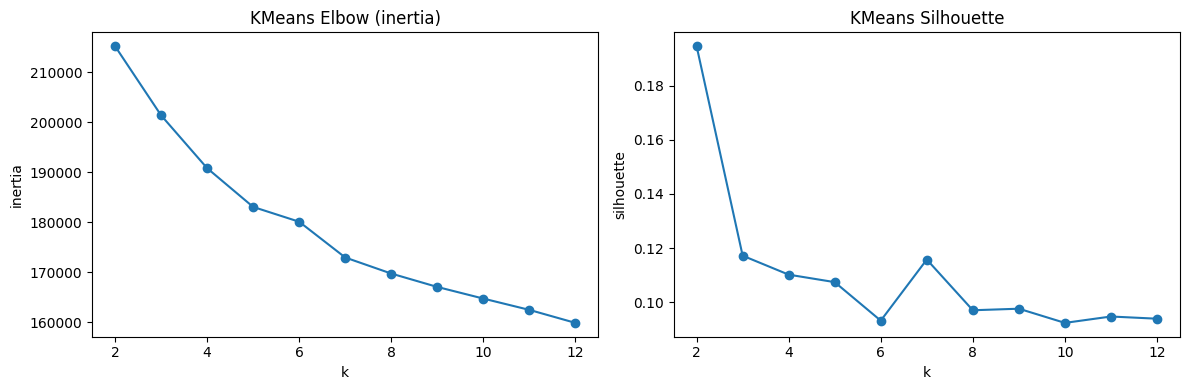

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Clustering comparisons (sorted by silhouette):
              method   k  silhouette    calinski    davies        inertia
0            KMeans   2    0.194543  997.592353  1.832430  215198.248493
1            KMeans   3    0.117191  676.056468  2.696382  201365.642420
5            KMeans   7    0.115764  376.279375  2.527764  172924.604669
2            KMeans   4    0.110185  552.503136  2.404555  190794.405789
3            KMeans   5    0.107419  475.946047  2.610211  183039.349767
12    Agglomerative   8    0.100857  314.109525  2.693871            NaN
7            KMeans   9    0.097611  310.364820  3.005863  167033.879515
6            KMeans   8    0.097041  339.804949  2.686332  169712.307309
9            KMeans  11    0.094731  266.935603  2.952109  162444.090039
10           KMeans  12    0.093920  252.699105  2.929367  159845.619031
4            KMeans   6    0.093205  400.636196  2.918631  180075.728420
8            KMeans  10    0.092376  286.240962  3.046305  164706.800372
11

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [9]:
X = combined_reduced
print("Clustering evaluation on X shape:", X.shape)

results = []

# KMeans: inertia & silhouette across K_RANGE
inertias = []
sil_scores = []
for k in K_RANGE:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    # silhouette requires >1 cluster and usually reasonable sample size
    try:
        sil = silhouette_score(X, labels)
    except Exception:
        sil = float("nan")
    sil_scores.append(sil)
    results.append({"method":"KMeans", "k":k, "silhouette":sil,
                    "calinski": calinski_harabasz_score(X, labels),
                    "davies": davies_bouldin_score(X, labels),
                    "inertia": km.inertia_})

# Plot elbow & silhouette
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(K_RANGE, inertias, '-o')
plt.title("KMeans Elbow (inertia)"); plt.xlabel("k"); plt.ylabel("inertia")
plt.subplot(1,2,2)
plt.plot(K_RANGE, sil_scores, '-o')
plt.title("KMeans Silhouette"); plt.xlabel("k"); plt.ylabel("silhouette")
plt.tight_layout()
plt.show()

# Try some alternative clustering algorithms (with pre-chosen n_clusters)
def safe_score_labels(X, labels):
    try:
        sil = silhouette_score(X, labels) if len(set(labels))>1 else float("nan")
    except Exception:
        sil = float("nan")
    try:
        ch = calinski_harabasz_score(X, labels) if len(set(labels))>1 else float("nan")
    except Exception:
        ch = float("nan")
    try:
        db = davies_bouldin_score(X, labels) if len(set(labels))>1 else float("nan")
    except Exception:
        db = float("nan")
    return sil, ch, db

# MiniBatchKMeans
mbk = MiniBatchKMeans(n_clusters=ALTERNATIVE_N_CLUSTERS, random_state=42, batch_size=1024)
labels = mbk.fit_predict(X)
sil, ch, db = safe_score_labels(X, labels)
results.append({"method":"MiniBatchKMeans","k":ALTERNATIVE_N_CLUSTERS,"silhouette":sil,"calinski":ch,"davies":db})

# Agglomerative
agg = AgglomerativeClustering(n_clusters=ALTERNATIVE_N_CLUSTERS)
labels = agg.fit_predict(X)
sil, ch, db = safe_score_labels(X, labels)
results.append({"method":"Agglomerative","k":ALTERNATIVE_N_CLUSTERS,"silhouette":sil,"calinski":ch,"davies":db})

# Spectral (may be heavy; try only if dataset not huge)
if len(X) < 3000:
    try:
        spec = SpectralClustering(n_clusters=ALTERNATIVE_N_CLUSTERS, random_state=42, affinity="nearest_neighbors", assign_labels="kmeans")
        labels = spec.fit_predict(X)
        sil, ch, db = safe_score_labels(X, labels)
        results.append({"method":"Spectral","k":ALTERNATIVE_N_CLUSTERS,"silhouette":sil,"calinski":ch,"davies":db})
    except Exception as e:
        print("Spectral failed:", e)

# DBSCAN (no k) - tune eps via heuristic; will often produce many noise points
try:
    dbs = DBSCAN(eps=1.0, min_samples=10, n_jobs=-1)
    labels = dbs.fit_predict(X)
    # compute only if we have more than 1 cluster
    if len(set(labels)) > 1:
        sil, ch, db = safe_score_labels(X, labels)
        results.append({"method":"DBSCAN","k":len(set(labels)) - (1 if -1 in labels else 0),"silhouette":sil,"calinski":ch,"davies":db})
except Exception as e:
    print("DBSCAN failed:", e)

results_df = pd.DataFrame(results).sort_values(by='silhouette', ascending=False)
print("\nClustering comparisons (sorted by silhouette):\n", results_df)
results_df.to_csv(os.path.join(OUT_DIR,"clustering_evaluation.csv"), index=False)


## Final Clustering

In [10]:
# auto-pick method with the highest silhouette from results_df (excluding NaNs)
best_row = results_df.dropna(subset=['silhouette']).sort_values('silhouette', ascending=False).head(1)
if not best_row.empty:
    best_method = best_row.iloc[0]['method']
    best_k = int(best_row.iloc[0]['k'])
    print("Auto-selected best clustering:", best_method, "k=", best_k)
else:
    # fallback
    best_method = "KMeans"
    best_k = 8
    print("Fallback selection:", best_method, "k=", best_k)

# Fit final chosen method
if best_method == "KMeans":
    final_clust = KMeans(n_clusters=best_k, random_state=42, n_init=10).fit(X)
    labels_final = final_clust.labels_
elif best_method == "MiniBatchKMeans":
    final_clust = MiniBatchKMeans(n_clusters=best_k, random_state=42).fit(X)
    labels_final = final_clust.labels_
elif best_method == "Agglomerative":
    final_clust = AgglomerativeClustering(n_clusters=best_k).fit(X)
    labels_final = final_clust.labels_
elif best_method == "Spectral":
    final_clust = SpectralClustering(n_clusters=best_k, random_state=42, affinity="nearest_neighbors", assign_labels="kmeans").fit(X)
    labels_final = final_clust.labels_
elif best_method == "DBSCAN":
    final_clust = DBSCAN(eps=1.0, min_samples=10, n_jobs=-1).fit(X)
    labels_final = final_clust.labels_
else:
    final_clust = KMeans(n_clusters=best_k, random_state=42, n_init=10).fit(X)
    labels_final = final_clust.labels_

df_proc['cluster_label'] = labels_final
joblib.dump(final_clust, os.path.join(OUT_DIR,"final_cluster_model.joblib"))
np.save(os.path.join(OUT_DIR,"final_labels.npy"), labels_final)
print("Saved final clustering model and labels.")


Auto-selected best clustering: KMeans k= 2
Saved final clustering model and labels.


## Publish-time analysis

In [11]:
day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

# We'll compute counts (or engagement-weighted sums if ENGAGEMENT_COL is set)
profile_records = []
clusters = np.unique(labels_final)
for c in clusters:
    df_c = df_proc[df_proc['cluster_label'] == c].copy()
    if ENGAGEMENT_COL:
        agg = df_c.groupby(['publish_day_of_week','publish_hour'])[ENGAGEMENT_COL].sum().reset_index(name='value')
    else:
        agg = df_c.groupby(['publish_day_of_week','publish_hour']).size().reset_index(name='value')
    # reindex to full grid
    grid = []
    for d in day_order:
        for h in range(24):
            v = agg.loc[(agg['publish_day_of_week'] == d) & (agg['publish_hour'] == h), 'value']
            v = float(v.iloc[0]) if len(v)>0 else 0.0
            grid.append({'cluster': int(c), 'day': d, 'hour': h, 'value': v})
    profile_records.extend(grid)

profiles_df = pd.DataFrame(profile_records)
# Normalize per-cluster to probabilities
profiles_df['prob'] = profiles_df.groupby('cluster')['value'].transform(lambda x: x / (x.sum() if x.sum()>0 else 1))

# Optionally smooth each cluster's 7x24 using a small kernel (not implemented here; can be added)

# Compute top-K recommendations per cluster
recs = []
for c in clusters:
    sub = profiles_df[profiles_df['cluster']==c].sort_values('prob', ascending=False).head(TOP_K_SLOTS)
    cluster_count = int((df_proc['cluster_label']==c).sum())
    for rank, row in enumerate(sub.itertuples(), start=1):
        recs.append({
            'cluster': int(c),
            'rank': rank,
            'day': row.day,
            'hour': int(row.hour),
            'score': float(row.prob),
            'cluster_count': cluster_count,
            'low_confidence': cluster_count < MIN_CLUSTER_SAMPLES
        })
recs_df = pd.DataFrame(recs).sort_values(['cluster','rank']).reset_index(drop=True)
print("Top recommendations per cluster (sample):")
print(recs_df.head(20))

# Save profile and recommendations
profiles_df.to_parquet(os.path.join(OUT_DIR,"cluster_publish_profiles.parquet"), index=False)
recs_df.to_parquet(os.path.join(OUT_DIR,"cluster_publish_recommendations.parquet"), index=False)
joblib.dump({'profiles_df': profiles_df, 'recs_df': recs_df}, os.path.join(OUT_DIR,"publish_profiles.joblib"))

Top recommendations per cluster (sample):
   cluster  rank        day  hour     score  cluster_count  low_confidence
0        0     1   Saturday    12  0.020268           2911           False
1        0     2     Sunday    12  0.017863           2911           False
2        0     3   Thursday    14  0.017863           2911           False
3        0     4   Thursday    13  0.017520           2911           False
4        0     5     Monday    12  0.017176           2911           False
5        1     1    Tuesday    15  0.031771           1259           False
6        1     2     Monday    15  0.029388           1259           False
7        1     3  Wednesday    15  0.027006           1259           False
8        1     4     Friday    15  0.023828           1259           False
9        1     5     Friday    11  0.023034           1259           False


['pipeline_artifacts/publish_profiles.joblib']

## Visualization

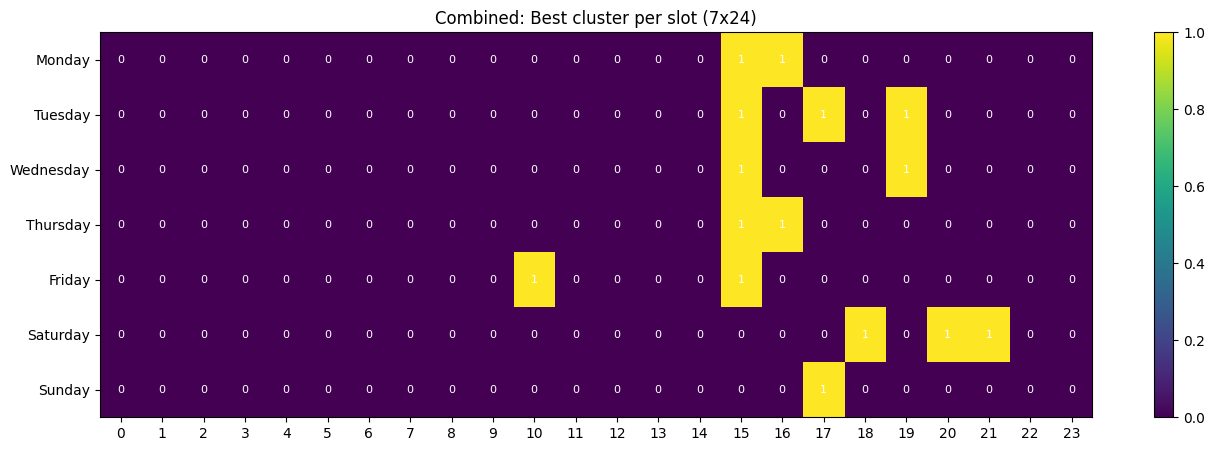

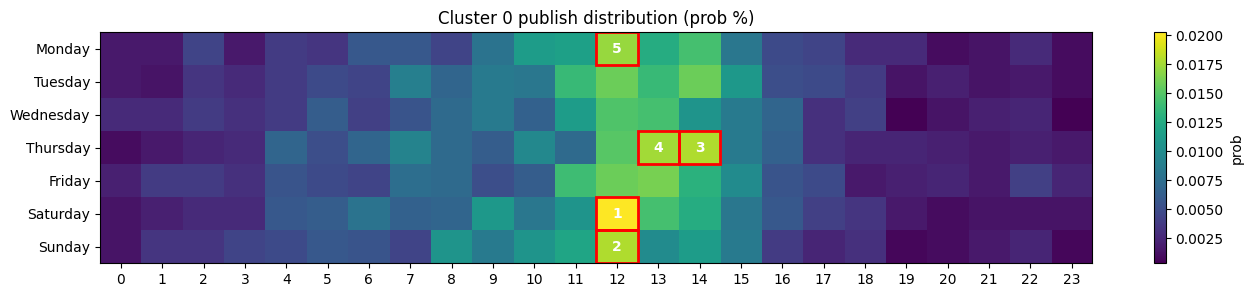

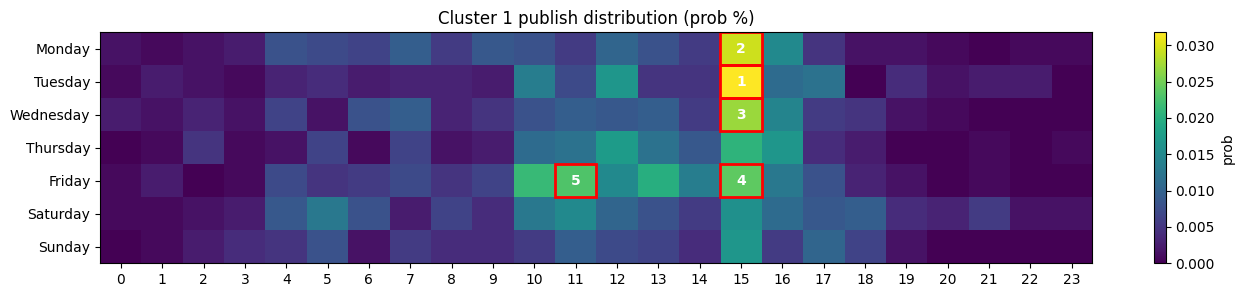

In [12]:
# Combined: best cluster per slot (by raw value)
pivot_totals = profiles_df.pivot_table(index='day', columns='hour', values='value', aggfunc='sum').reindex(day_order)
# compute best cluster per slot
slot_best = np.full((7,24), fill_value=-1, dtype=int)
for i,d in enumerate(day_order):
    for h in range(24):
        slot_vals = profiles_df[(profiles_df['day']==d) & (profiles_df['hour']==h)].set_index('cluster')['value']
        if slot_vals.sum() == 0:
            slot_best[i,h] = -1
        else:
            slot_best[i,h] = int(slot_vals.idxmax())

plt.figure(figsize=(16,5))
plt.imshow(slot_best, aspect='auto', origin='upper')
plt.yticks(np.arange(7), day_order)
plt.xticks(np.arange(24), np.arange(24))
plt.title("Combined: Best cluster per slot (7x24)")
for i in range(7):
    for j in range(24):
        if slot_best[i,j] != -1:
            plt.text(j, i, str(slot_best[i,j]), color='white', ha='center', va='center', fontsize=8)
plt.colorbar()
plt.show()

# Per-cluster heatmaps
n_clusters = len(clusters)
for c in clusters:
    mat = profiles_df[profiles_df['cluster']==c].pivot_table(index='day', columns='hour', values='prob', fill_value=0).reindex(day_order)
    plt.figure(figsize=(16,3))
    plt.imshow(mat.values, aspect='auto', origin='upper', cmap='viridis')
    plt.title(f"Cluster {int(c)} publish distribution (prob %)")
    plt.yticks(np.arange(7), day_order)
    plt.xticks(np.arange(24), np.arange(24))
    # annotate top K slots
    top_rows = recs_df[recs_df['cluster']==c].head(TOP_K_SLOTS)
    for _, r in top_rows.iterrows():
        day_i = day_order.index(r['day'])
        hr = int(r['hour'])
        plt.gca().add_patch(plt.Rectangle((hr-0.5, day_i-0.5), 1, 1, linewidth=2, edgecolor='red', facecolor='none'))
        plt.text(hr, day_i, str(int(r['rank'])), color='white', ha='center', va='center', weight='bold')
    plt.colorbar(label='prob')
    plt.show()


## Save Everything

In [13]:
joblib.dump({
    'df_proc_path': df_proc_path,
    'preproc_objs': os.path.join(OUT_DIR,"preproc_objs.joblib"),
    'combined_embeddings': os.path.join(OUT_DIR,"combined_embeddings.npy"),
    'cluster_model': os.path.join(OUT_DIR,"final_cluster_model.joblib"),
    'profiles': os.path.join(OUT_DIR,"cluster_publish_profiles.parquet"),
    'recs': os.path.join(OUT_DIR,"cluster_publish_recommendations.parquet")
}, os.path.join(OUT_DIR,"artifact_index.joblib"))

joblib.dump({
    'scaler': scaler,
    'encoder': encoder,
    'pca': pca,
    'model_name': CLIP_MODEL_NAME,
    'try_images': TRY_USE_IMAGES,
    'device': DEVICE
}, os.path.join(OUT_DIR,"runtime_objects.joblib"))



['pipeline_artifacts/runtime_objects.joblib']

## Inferencing

In [14]:
# Note: This function assumes processor and model are still loaded in this python session.
def embed_single_image_from_url(url, target_size=(224,224)):
    arr = load_and_resize_image_from_url(url, target_size)
    if arr is None:
        return np.zeros((model.config.projection_dim,))
    inp = Image.fromarray(arr)
    inputs = processor(images=inp, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        emb = model.get_image_features(**inputs).cpu().numpy()
    return emb[0]

def embed_single_text(text):
    inputs = processor(text=[text], return_tensors="pt", padding=True, truncation=True).to(DEVICE)
    with torch.no_grad():
        emb = model.get_text_features(**inputs).cpu().numpy()
    return emb[0]

# load saved preproc objects
preproc = joblib.load(os.path.join(OUT_DIR,"preproc_objs.joblib"))
scaler_infer = preproc['scaler'] if 'scaler' in preproc else scaler
encoder_infer = preproc['encoder'] if 'encoder' in preproc else encoder
pca_infer = preproc['pca'] if 'pca' in preproc else pca

final_cluster_model = joblib.load(os.path.join(OUT_DIR,"final_cluster_model.joblib"))
profiles = pd.read_parquet(os.path.join(OUT_DIR,"cluster_publish_profiles.parquet"))
recs_saved = pd.read_parquet(os.path.join(OUT_DIR,"cluster_publish_recommendations.parquet"))

def predict_publish_times(new_video, top_k=TOP_K_SLOTS, skip_images=False):
    """
    new_video: dict with keys: title, description, video_tags, langauge, categoryId, duration_seconds, thumbnail_url, is_holiday
    returns: cluster_label, top_k recommendations DataFrame
    """
    # text
    text_input = " ".join([
        str(new_video.get('title','')),
        str(new_video.get('description','')),
        str(new_video.get('video_tags','')),
        str(new_video.get('langauge',''))
    ])
    text_embedding = embed_single_text(text_input)

    # image
    if TRY_USE_IMAGES and not skip_images:
        try:
            image_embedding = embed_single_image_from_url(new_video.get('thumbnail_url',''))
        except Exception:
            image_embedding = np.zeros((model.config.projection_dim,))
    else:
        image_embedding = np.zeros((model.config.projection_dim,))

    # numeric + categorical
    duration = float(new_video.get('duration_seconds', 0.0))
    duration_norm = scaler_infer.transform([[duration]])[0]
    cat_enc = encoder_infer.transform([[str(new_video.get('categoryId','')), str(int(new_video.get('is_holiday',0)))]])[0]

    combined_vec = np.hstack([image_embedding, text_embedding, duration_norm, cat_enc]).reshape(1, -1)
    if pca_infer is not None:
        combined_vec = pca_infer.transform(combined_vec)

    # predict cluster
    try:
        cluster_label = int(final_cluster_model.predict(combined_vec)[0])
    except Exception:
        # if model uses labels_ or fit_predict
        if hasattr(final_cluster_model, "labels_"):
            cluster_label = int(final_cluster_model.labels_[0])
        else:
            cluster_label = 0

    # lookup top-k
    recs = recs_saved[recs_saved['cluster']==cluster_label].sort_values('rank').head(top_k)
    return cluster_label, recs


## Predictions

In [15]:
def visualize_cluster_recommendations(cluster_label, profiles, top_k=5):
    """
    Visualize the publish time distribution for a cluster as a 7x24 heatmap
    and highlight top recommended slots.
    """
    cluster_profile = profiles[profiles['cluster'] == cluster_label].copy()

    # Detect correct column names
    day_col = None
    hour_col = None
    prob_col = None
    for col in cluster_profile.columns:
        lc = col.lower()
        if "day" in lc:
            day_col = col
        elif "hour" in lc:
            hour_col = col
        elif "prob" in lc or "score" in lc:
            prob_col = col

    if not all([day_col, hour_col, prob_col]):
        raise ValueError(f"Could not find day/hour/prob columns in profiles. Found columns: {cluster_profile.columns}")

    # Pivot into heatmap
    heatmap_data = cluster_profile.pivot_table(
        index=day_col,
        columns=hour_col,
        values=prob_col,
        fill_value=0
    )

    # Order days properly if possible
    day_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    heatmap_data = heatmap_data.reindex(day_order, fill_value=0)

    # Plot heatmap
    plt.figure(figsize=(14,6))
    sns.heatmap(
        heatmap_data, cmap="YlGnBu", linewidths=.5, annot=False,
        cbar_kws={'label': 'Probability of Good Performance'}
    )
    plt.title(f"Optimal Publish Times - Cluster {cluster_label}", fontsize=16)
    plt.xlabel("Hour of Day")
    plt.ylabel("Day of Week")
    plt.show()

    # Return top-k slots
    top_slots = cluster_profile.sort_values(prob_col, ascending=False).head(top_k)
    return top_slots


In [16]:
new_video_example = {
    "title": "දුවට සම්මානයක් හම්බවෙනකොට දෙමව්පියොන්ට තමයි වැඩියෙන්ම සතුට💕#shorts #trending",
    "description": "popular award srilanka #sinhala #teledrama #mayawee.",
    "video_tags": "demo,example",
    "langauge": "si",
    "categoryId": "22",
    "duration_seconds": 120,
    "thumbnail_url": "https://i.ytimg.com/vi/9s0zMADyyis/default.jpg",
    "is_holiday": 0
}
cluster, recs = predict_publish_times(new_video_example)
print("Assigned cluster:", cluster)
print(recs)

Assigned cluster: 0
   cluster  rank       day  hour     score  cluster_count  low_confidence
0        0     1  Saturday    12  0.020268           2911           False
1        0     2    Sunday    12  0.017863           2911           False
2        0     3  Thursday    14  0.017863           2911           False
3        0     4  Thursday    13  0.017520           2911           False
4        0     5    Monday    12  0.017176           2911           False


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


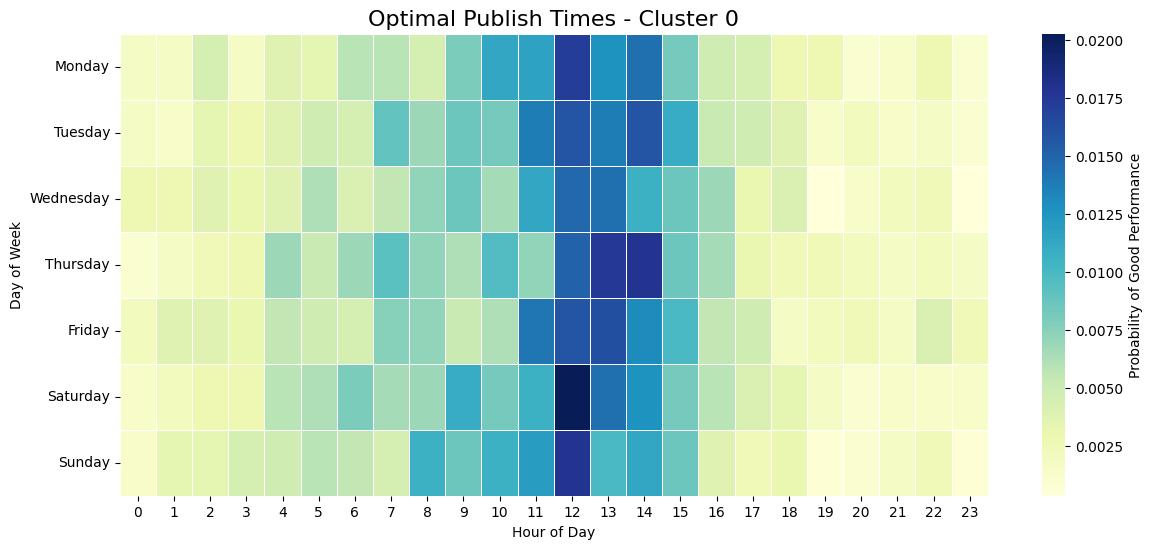

Best Slots (from heatmap):
     cluster       day  hour  value      prob
132        0  Saturday    12   59.0  0.020268
156        0    Sunday    12   52.0  0.017863
86         0  Thursday    14   52.0  0.017863
85         0  Thursday    13   51.0  0.017520
12         0    Monday    12   50.0  0.017176


In [17]:
top_slots = visualize_cluster_recommendations(cluster, profiles, top_k=5)
print("Best Slots (from heatmap):")
print(top_slots)